## Inside a Boiler - Slagging Prediction
#### https://opendata.edp.com/pages/challenges/#description

In [1]:
### Chec#from imblearn.combine import SMOTETomek
import pandas as pd 
import numpy as np 
from numpy import sort, sqrt, argsort, inf
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, precision_recall_curve,confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [2]:
data_unit_y_year_2 = pd.read_csv('..\\data\\boiler_unity_xxx2.csv',sep=';')

### Check: hay variables de temperatura que, según la literatura, podrían ser altamente informativas?

In [3]:
temperature_columns_mask = ['temperature' in x for x in data_unit_y_year_2.columns]
data_unit_y_year_2.columns[temperature_columns_mask]


Index([], dtype='object')

### Eliminamos variables altamente correladas entre sí

In [ ]:
import pandas_profiling

df_profile = pandas_profiling.ProfileReport(data_unit_y_year_2.iloc[:50])
df_profile.to_widgets()

In [4]:
'''
    En base a las correlaciones obtenidas en el profiling:
    - añado 'Boiler_Feedwater_Pressure'
    - elimino los cold primary air y me quedo con los hot primary air
    - añado 'Air Heater #1 Differential Pressure'
    - elimino 'Total_Boiler_Feedwater_Flow'
    - elimino los Flue gas damper position: por algo de experiencia, los valores que indican 
      posiciones de accionamientos no suelen informar de estados de procesos; además, el histograma de valores
      más anómalos (entre 0 y 10) no se dan en torno a las fechas de slag
    - 

'''
'''
selected_colums_yirman = ['SSTIMESTAMP',
'Active_Power',
'Boiler_Feedwater_Pressure',
'Boiler_Furnace_Pressure',
'Boiler_Outlet_Pressure',
'Coal_Feeder_#1',
'Coal_Feeder_#5',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#1',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#2',
'Dynamic_Coal_Classifier_Rotational_Speed_Coal_Mill_#3',
'Secondary_Air_Row_#3_(Side_2)',
'Secondary_Air_Row_#5_(Side_2)',
'Boosted_Overfire_Air_(Side_1)',
'Boosted_Overfire_Air_(Side_2)',
'Secondary_Air_Fan_#1_Temperature_2',
'Flue_Gas_Induced_Draft_Fan_#1_Blade_Pitch_Angle',
'Total_Atemperator_Feedwater_Flow',
'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_1)',
'Main_Steam_First_Desuperheater_Control_Valve_position_(Side_2)',
'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_1)',
'Main_Steam_Second_Desuperheater_Control_Valve_position_(Side_2)',
'Main_Steam_Turbine_Control_Valve_#B',
'Main_Steam_Turbine_Control_Valve_#D',
'Air_Heater_#1_Differential_Pressure',
'Reheated_Steam_Temperature_1_@Outlet']
'''
selected_colums_yirman = ['SSTIMESTAMP',
'Active Power',
'Boiler Feedwater Pressure',
'Boiler Furnace Pressure',
'Boiler Outlet Pressure',
'Coal Feeder #1',
'Coal Feeder #5',
'Dynamic Coal Classifier Rotational Speed Coal Mill #1',
'Dynamic Coal Classifier Rotational Speed Coal Mill #2',
'Dynamic Coal Classifier Rotational Speed Coal Mill #3',
'Secondary Air Row #3 (Side 2)',
'Secondary Air Row #5 (Side 2)',
'Boosted Overfire Air (Side 1)',
'Boosted Overfire Air (Side 2)',
'Secondary Air Fan #1 Temperature 2',
'Flue Gas Induced Draft Fan #1 Blade Pitch Angle',
'Total Atemperator Feedwater Flow',
'Main Steam First Desuperheater Control Valve position (Side 1)',
'Main Steam First Desuperheater Control Valve position (Side 2)',
'Main Steam Second Desuperheater Control Valve position (Side 1)',
'Main Steam Second Desuperheater Control Valve position (Side 2)',
'Main Steam Turbine Control Valve #B',
'Main Steam Turbine Control Valve #D',
'Air Heater #1 Differential Pressure',
'Reheated Steam Temperature 1 @Outlet']

data = data_unit_y_year_2[selected_colums_yirman]

In [5]:
'''
data = data[selected_colums_yirman]
na_cols = [x for x in data.columns if x in data.columns[data.isnull().any()].tolist()]
for col in na_cols:
    data[col] = data[col].fillna(data[col].mean())
'''
#%%
def q10(x):
    return x.quantile(0.1)

### Para sampleo diario

In [6]:
'''
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo diario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

unique_ID_values = data['ID'].unique()
unique_days = [x.split('-')[0] for x in unique_ID_values]
unique_months = [x.split('-')[1] for x in unique_ID_values]

tablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})
features = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]
for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)
    prueba = prueba.add_prefix(col+'_')
    tablon_final = pd.concat([tablon_final, prueba],axis=1)
'''

"\n### Feature engineering: \n### 1.- en base a atributos estadísticos en sampleo diario\n## ToDo:\n### 2.- igual pero con otro sampling frequency\n### 3.- añadiendo atributo de tendencias y/o estacionalidad\n### 4.- TSFresh\n\nunique_ID_values = data['ID'].unique()\nunique_days = [x.split('-')[0] for x in unique_ID_values]\nunique_months = [x.split('-')[1] for x in unique_ID_values]\n\ntablon_final = pd.DataFrame({'ID': unique_ID_values, 'DAY': unique_days, 'MONTH': unique_months})\nfeatures = [x for x in data.columns if x not in ['TIME', 'HOUR', 'DAY', 'MONTH', 'ID']]\nfor col in features:\n    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED\n    prueba = data.groupby(['ID'])[col].agg(['count','mean','max','min','std','skew',q10]).reset_index(drop=True)\n    prueba = prueba.add_prefix(col+'_')\n    tablon_final = pd.concat([tablon_final, prueba],axis=1)\n"

### Para sampleo horario <font color='red'> (probar también con resampleo cada 4 horas por ejemplo) </font>

In [7]:

data['SSTIMESTAMP'][:3]

0    07-05-xxx2 18:40:00
1    07-05-xxx2 18:45:00
2    07-05-xxx2 18:50:00
Name: SSTIMESTAMP, dtype: object

### Creamos atributo ID con la combinación de mes+día+hora

In [8]:
datetime_values = data['SSTIMESTAMP']
hours_values = pd.Series([x.split(' ')[1].split(':')[0] for x in datetime_values]) 
days_values = pd.Series([x.split(' ')[0].split('-')[0] for x in datetime_values])
months_values = pd.Series([x.split(' ')[0].split('-')[1] for x in datetime_values])

frequency_sampling_ID = list([months_values[0]+'-'+days_values[0]+'-'+hours_values[0]])
for index in range(1, len(hours_values)):
    frequency_sampling_ID.append(months_values[index]+'-'+days_values[index]+'-'+hours_values[index])
data['ID_sampling'] = frequency_sampling_ID 

### Check: cada agrupación por ID_sampling debe contener 12 elementos (12 packs de 5 min por hora)

In [9]:
data.groupby(['ID_sampling'])['SSTIMESTAMP'].agg(['count'])

,count
ID_sampling,
01-01-00,12
01-01-01,12
01-01-02,12
01-01-03,12
01-01-04,12
...,...
12-31-19,12
12-31-20,12
12-31-21,12


In [10]:
data.head(5)
data.tail(5)

,SSTIMESTAMP,Active Power,Boiler Feedwater Pressure,Boiler Furnace Pressure,Boiler Outlet Pressure,Coal Feeder #1,Coal Feeder #5,Dynamic Coal Classifier Rotational Speed Coal Mill #1,Dynamic Coal Classifier Rotational Speed Coal Mill #2,Dynamic Coal Classifier Rotational Speed Coal Mill #3,...,Total Atemperator Feedwater Flow,Main Steam First Desuperheater Control Valve position (Side 1),Main Steam First Desuperheater Control Valve position (Side 2),Main Steam Second Desuperheater Control Valve position (Side 1),Main Steam Second Desuperheater Control Valve position (Side 2),Main Steam Turbine Control Valve #B,Main Steam Turbine Control Valve #D,Air Heater #1 Differential Pressure,Reheated Steam Temperature 1 @Outlet,ID_sampling
105115,31-12-xxx2 12:55:00,0.964155,206.4453,-0.761719,-8.789063,30.70313,30.79102,100.1465,-0.292969,86.42578,...,36.38478,0.390625,21.94824,24.43848,40.89355,105.5673,37.35439,16.23535,526.6379,12-31-12
105116,31-12-xxx2 13:10:00,0.964846,206.2500,-0.878906,-8.984375,30.75195,30.91797,100.1465,-0.292969,85.88867,...,36.00537,0.439453,21.89941,19.31152,41.96777,105.4666,39.04653,16.30859,526.6379,12-31-13
105117,31-12-xxx2 13:20:00,0.965294,206.2500,-0.761719,-8.847656,30.54688,30.74219,100.1465,-0.292969,85.74219,...,36.76028,0.439453,22.80273,19.23828,41.25977,105.7184,39.86343,16.29639,526.6379,12-31-13
105118,31-12-xxx2 13:25:00,0.965500,206.2500,-0.546875,-8.652344,30.60547,30.89844,100.1465,-0.292969,86.42578,...,36.38478,0.439453,22.55859,20.04395,35.69336,105.7184,40.03848,16.36353,527.2504,12-31-13
105119,31-12-xxx2 13:55:00,0.966511,206.7383,-0.820312,-8.886719,30.79102,30.87891,100.1465,-0.292969,86.42578,...,34.20591,0.610352,20.62988,20.36133,36.81641,105.5170,44.06460,16.48560,527.2504,12-31-13


### Statistical features engineering

In [11]:
### Feature engineering: 
### 1.- en base a atributos estadísticos en sampleo horario
## ToDo:
### 2.- igual pero con otro sampling frequency
### 3.- añadiendo atributo de tendencias y/o estacionalidad
### 4.- TSFresh

tablon_final = pd.DataFrame({'ID_sampling': frequency_sampling_ID, 'HOUR': hours_values, 'DAY': days_values, 'MONTH': months_values})
tablon_final.drop_duplicates(subset='ID_sampling', keep='first', inplace=True)
tablon_final.set_index('ID_sampling', inplace=True)

features = [x for x in data.columns if x not in ['ID_sampling', 'HOUR', 'DAY', 'MONTH', 'SSTIMESTAMP']]

for col in features:
    #AÑADIR MEAN Y MEDIAN EXPONENTIALLY WEIGHTED
    data_hourly_grouped = data.groupby(['ID_sampling'])[col].agg(['median','mean','max','min','std','skew']).reset_index(drop=True)
    data_hourly_grouped = data_hourly_grouped.add_prefix(col+'_')
    data_hourly_grouped.index = tablon_final.index
    tablon_final = pd.concat([tablon_final, data_hourly_grouped],axis=1)


In [12]:
tablon_final.head(5)


,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,Active Power_skew,Boiler Feedwater Pressure_median,...,Air Heater #1 Differential Pressure_max,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew
ID_sampling,,,,,,,,,,,,,,,,,,,,,
05-07-18,18,07,05,0.969362,0.969339,0.974776,0.964863,0.002600,0.221930,208.74025,...,12.92114,12.45728,0.128844,-1.504877,530.71995,530.865042,531.9487,530.2197,0.443263,1.384931
05-07-19,19,07,05,0.968115,0.968051,0.969804,0.965298,0.001423,-0.489962,208.69140,...,12.67090,12.46338,0.061881,0.280133,529.65580,529.748775,530.2197,529.6558,0.217158,2.055890
05-07-20,20,07,05,0.967400,0.967584,0.970033,0.964842,0.001625,-0.120457,208.39840,...,12.59155,12.42676,0.058260,-0.454415,530.31420,530.438350,530.8199,530.2076,0.285210,0.728890
05-07-21,21,07,05,0.968011,0.968120,0.971448,0.964927,0.001766,0.112577,208.39840,...,12.55493,12.40845,0.050158,0.093290,529.44605,529.677217,530.3142,529.1327,0.588873,0.173163
05-07-22,22,07,05,0.968090,0.968190,0.973212,0.964162,0.002647,0.461466,207.81250,...,12.69531,12.39014,0.102034,0.093195,529.69830,528.985675,529.6983,526.1230,1.395905,-1.764220


### Se añaden atributos temporales y se ordena por mes, día y hora

In [13]:
tablon_final.MONTH = tablon_final.MONTH.astype('int32')
tablon_final.DAY = tablon_final.DAY.astype('int32')
tablon_final.HOUR = tablon_final.HOUR.astype('int32')

tablon_final.sort_values(by=['MONTH', 'DAY', 'HOUR'], ascending=[1, 1, 1], inplace=True)

tablon_final.tail()

,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,Active Power_skew,Boiler Feedwater Pressure_median,...,Air Heater #1 Differential Pressure_max,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew
ID_sampling,,,,,,,,,,,,,,,,,,,,,
12-31-19,19,31,12,0.327980,0.328251,0.329503,0.327614,0.000622,1.038830,189.35550,...,7.507324,7.440186,0.030499,0.707223,503.3811,503.111142,503.9383,502.2818,0.597675,-0.263358
12-31-20,20,31,12,0.325991,0.329366,0.346467,0.322904,0.008539,1.514106,189.45310,...,8.392334,7.354736,0.284228,3.410435,503.7989,504.047567,505.1213,503.2954,0.565929,1.224989
12-31-21,21,31,12,0.326058,0.325015,0.327282,0.317474,0.002718,-2.362497,189.69725,...,7.489014,7.354736,0.043585,-1.481554,503.2954,503.295400,503.2954,503.2954,0.000000,0.000000
12-31-22,22,31,12,0.325684,0.325704,0.334341,0.316690,0.003811,-0.171542,189.45310,...,7.531738,6.384277,0.398307,-2.044275,503.2954,503.393600,503.8846,503.2954,0.229346,2.055237
12-31-23,23,31,12,0.631711,0.581360,0.725705,0.321537,0.142511,-0.661629,192.43165,...,12.188720,7.043457,1.606534,-0.007160,510.0666,513.553708,526.8130,502.7367,10.079683,0.434543


## Añadimos los días que preceden al efecto de slag

In [14]:
### El resto de días no nos preocupa, ya que caeríamos dentro de los falsos positivos 
warning_window_dates = ['01-08', '02-08', '03-08', '04-08', '05-08', '06-08', '07-08', '08-08', '09-08',
                        '10-08', '11-08', '12-08', '13-08', '14-08', '15-08', '16-08', '17-08', '18-08', '19-08',
                        '20-08', '21-08', '22-08', '23-08', '24-08', '25-08', '26-08', '27-08', '28-08', '29-08', '30-08']

In [15]:
# el slagging day registrado para el boiler 3 en el año 3 es: 3-11-XXX3
slag_day_reference = 37 #(30 días de agosto + 7 de septiembre como referencia)
tablon_final['DAYS_TILL_SLAG'] = 0 

for date in warning_window_dates: 
    warning_month = int(date.split('-')[1])
    warning_day = int(date.split('-')[0])
    
    tablon_final['DAYS_TILL_SLAG'] = \
        np.where(((tablon_final.MONTH==warning_month)&(tablon_final.DAY==warning_day)),slag_day_reference-warning_day,
                   tablon_final['DAYS_TILL_SLAG'])


In [16]:
tablon_final[tablon_final.DAYS_TILL_SLAG>0]


,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,Active Power_skew,Boiler Feedwater Pressure_median,...,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew,DAYS_TILL_SLAG
ID_sampling,,,,,,,,,,,,,,,,,,,,,
08-01-00,0,1,8,0.958815,0.959237,0.965213,0.956246,0.002301,1.609777,206.7383,...,15.411380,0.094032,0.645404,531.42760,531.443342,532.0732,530.9030,0.251114,0.635346,36
08-01-01,1,1,8,0.966662,0.966490,0.969262,0.962819,0.002109,-0.406362,208.3008,...,12.902830,0.060861,-0.143082,531.71750,531.599175,532.0225,530.7657,0.491422,-0.685063,36
08-01-02,2,1,8,0.965354,0.965678,0.968457,0.964219,0.001413,1.170853,208.3496,...,12.896730,0.046733,-0.012644,531.28370,531.468400,532.0225,531.2837,0.334135,1.326650,36
08-01-03,3,1,8,0.965793,0.966515,0.970724,0.963586,0.002378,0.800437,208.4961,...,12.701420,0.104760,0.860863,531.89380,531.781642,532.5149,529.9268,0.610804,-2.859452,36
08-01-04,4,1,8,0.965922,0.966124,0.973140,0.959403,0.003500,0.152811,208.3008,...,12.750240,0.043925,0.695853,530.39990,530.312600,531.1095,528.6983,0.872933,-0.713573,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08-30-19,19,30,8,0.971278,0.971337,0.974060,0.967401,0.002018,-0.428993,207.0313,...,9.613037,0.063667,-0.007311,531.84300,531.738250,531.9158,531.1624,0.262558,-2.027535,7
08-30-20,20,30,8,0.971595,0.971354,0.974626,0.967987,0.001951,-0.028404,206.6406,...,9.747314,0.041546,0.211384,531.51495,531.625325,532.4406,531.1624,0.485932,0.645462,7
08-30-21,21,30,8,0.972455,0.973266,0.980030,0.970104,0.002906,1.392269,206.7871,...,9.759521,0.120070,0.615403,530.55570,530.596875,531.7551,529.6916,0.551928,0.592084,7


### Etiquetamos clases binarias. 

### Posteriormente, etiqutado multiclase para dar mayor relevancia en las predicciones de nuestros positivos (efecto slag) a los registros etiquetados como 4, luego 3... ya que nuestra hipótesis es que el efecto debe ser más evidente en días más próximos al efecto slag, y esto es más avanzados en nuestro warning window


In [17]:
tablon_final['TARGET'] = 0

mask_label = (tablon_final.DAYS_TILL_SLAG < 30)&(tablon_final.DAYS_TILL_SLAG >= 9)
mask_indexes = tablon_final[mask_label].index 
tablon_final.loc[mask_indexes, 'TARGET'] = 1


In [18]:
tablon_final[tablon_final.TARGET>0][['MONTH', 'DAY', 'DAYS_TILL_SLAG', 'TARGET']]

,MONTH,DAY,DAYS_TILL_SLAG,TARGET
ID_sampling,,,,
08-08-00,8,8,29,1
08-08-01,8,8,29,1
08-08-02,8,8,29,1
08-08-03,8,8,29,1
08-08-04,8,8,29,1
...,...,...,...,...
08-28-19,8,28,9,1
08-28-20,8,28,9,1
08-28-21,8,28,9,1


### Construimos nuestro input attributes y el target

In [19]:
#inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
inputs = [x for x in tablon_final.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X = tablon_final[inputs]
y = tablon_final['TARGET']

### Interpolamos valores ausentes: método lineal para datos de sensores

In [20]:
def imputeMissingInterpolating(array_df, features_to_impute):
    import numpy as np
    for attr in features_to_impute:
        attribute_interpolated = array_df[attr].interpolate(method='linear', limit_direction='both')
        #print('nans length for {}: {}'.format(attr, len(attribute_interpolated[np.isnan(attribute_interpolated)])))
        assert len(attribute_interpolated[np.isnan(attribute_interpolated)]) == 0
        
        array_df[attr] = attribute_interpolated
    
    return array_df

X_interpolated = imputeMissingInterpolating(X, X.columns[X.isna().any()])
X_interpolated.head(3)

,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,Active Power_skew,Boiler Feedwater Pressure_median,Boiler Feedwater Pressure_mean,Boiler Feedwater Pressure_max,Boiler Feedwater Pressure_min,...,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew,DAYS_TILL_SLAG
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0.964467,0.964946,0.971731,0.961250,0.002775,1.204164,207.9102,207.600925,208.0078,206.4453,...,12.35962,0.085427,0.558582,530.9978,531.264917,531.8762,530.4045,0.580417,-0.126744,0
01-01-01,0.965041,0.965050,0.971931,0.959900,0.003187,0.669930,207.2754,207.332367,208.1055,206.4453,...,12.40234,0.097996,-0.275233,533.1464,533.131875,533.6511,532.5592,0.234602,-0.407787,0
01-01-02,0.964901,0.965084,0.967879,0.961571,0.001888,-0.322302,207.4219,207.560217,208.1055,207.3242,...,12.44507,0.075584,0.900881,533.0904,532.903167,533.0904,532.4982,0.277173,-0.828460,0


In [21]:
X_interpolated.columns[X_interpolated.isna().any()]

Index([], dtype='object')

### Escalamos valores estandarizando: standard scaler

In [22]:
def scale_and_save_scaler(dataframe, features_to_scale, df_to_concat, saving_path=False):
    try:
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        from joblib import dump

        #husillo m22
        standard_scaler = StandardScaler()
        standard_scaler.fit(dataframe[features_to_scale].values)
        scaled_dataframe_values = standard_scaler.transform(dataframe[features_to_scale].values)
        scaled_dataframe = pd.DataFrame(columns=features_to_scale, data=scaled_dataframe_values, index = dataframe.index)
        
        features_no_to_scale = [x for x in dataframe.columns if x not in features_to_scale]
        
        assert dataframe.index.all() == scaled_dataframe.index.all()
        
        final_scaled_df = pd.concat([df_to_concat, scaled_dataframe], axis=1) 
        
        if saving_path:
            dump(standard_scaler, saving_path) 

        return final_scaled_df

    except Exception as exc:
        print(exc)
        #return exc

numeric_features = [x for x in tablon_final.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
dataset_to_concat = tablon_final[['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]
X_scaled_interpolated = scale_and_save_scaler(X_interpolated, features_to_scale = numeric_features, df_to_concat = dataset_to_concat)

In [23]:
X_scaled_interpolated.tail()

,TARGET,DAYS_TILL_SLAG,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,...,Air Heater #1 Differential Pressure_max,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew
ID_sampling,,,,,,,,,,,,,,,,,,,,,
12-31-19,0,0,19,31,12,-2.699895,-2.710722,-2.830760,-2.570387,-0.330922,...,-1.705630,-1.507947,-0.448039,0.714910,-0.340337,-0.345679,-0.357456,-0.333201,-0.171806,-0.242713
12-31-20,0,0,20,31,12,-2.709318,-2.705418,-2.747917,-2.592037,0.064814,...,-1.435083,-1.533333,0.328350,3.819047,-0.331949,-0.326868,-0.333481,-0.313031,-0.191312,1.236952
12-31-21,0,0,21,31,12,-2.708999,-2.726121,-2.841609,-2.617003,-0.226161,...,-1.711228,-1.533333,-0.407997,-1.798494,-0.342057,-0.341978,-0.370485,-0.313031,-0.539043,0.019109
12-31-22,0,0,22,31,12,-2.710773,-2.722842,-2.807134,-2.620606,-0.171512,...,-1.698167,-1.821644,0.677424,-2.444675,-0.342057,-0.340005,-0.358544,-0.313031,-0.398123,2.062358
12-31-23,0,0,23,31,12,-1.260923,-1.506261,-0.895884,-2.598325,6.760938,...,-0.274528,-1.625810,4.374496,-0.105426,-0.206119,-0.135903,0.106124,-0.324149,5.654344,0.451118


### Guardamos X_scaled_interpolated

In [24]:
X_scaled_interpolated.to_csv('../data/boiler_Y_train_data_scaled_interpolated.csv')

In [25]:
X_scaled_interpolated_from_csv = pd.read_csv('../data/boiler_Y_train_data_scaled_interpolated.csv')

In [26]:
X_scaled_interpolated_from_csv.set_index('ID_sampling', inplace=True)

In [27]:
X_scaled_interpolated_from_csv

,TARGET,DAYS_TILL_SLAG,HOUR,DAY,MONTH,Active Power_median,Active Power_mean,Active Power_max,Active Power_min,Active Power_std,...,Air Heater #1 Differential Pressure_max,Air Heater #1 Differential Pressure_min,Air Heater #1 Differential Pressure_std,Air Heater #1 Differential Pressure_skew,Reheated Steam Temperature 1 @Outlet_median,Reheated Steam Temperature 1 @Outlet_mean,Reheated Steam Temperature 1 @Outlet_max,Reheated Steam Temperature 1 @Outlet_min,Reheated Steam Temperature 1 @Outlet_std,Reheated Steam Temperature 1 @Outlet_skew
ID_sampling,,,,,,,,,,,,,,,,,,,,,
01-01-00,0,0,0,1,1,0.315556,0.319098,0.305600,0.342672,-0.223289,...,-0.115931,-0.046446,-0.279965,0.544224,0.214093,0.219890,0.208735,0.226438,-0.182410,-0.106896
01-01-01,0,0,1,1,1,0.318278,0.319591,0.306575,0.336465,-0.202701,...,-0.108469,-0.033755,-0.241505,-0.413258,0.257228,0.257395,0.244705,0.269316,-0.394893,-0.386300
01-01-02,0,0,2,1,1,0.317615,0.319754,0.286789,0.344149,-0.267642,...,-0.121528,-0.021060,-0.310082,0.937290,0.256104,0.252800,0.233342,0.268102,-0.368736,-0.804519
01-01-03,0,0,3,1,1,0.315965,0.318521,0.292057,0.332920,-0.204081,...,-0.115931,-0.064581,-0.157281,-1.464765,0.216385,0.209147,0.206487,0.211628,-0.002055,-0.171798
01-01-04,0,0,4,1,1,0.329135,0.321204,0.372476,0.277699,0.113230,...,-0.033835,-0.104470,0.084728,-0.098153,0.182917,0.155309,0.182932,0.089825,1.060142,-0.943097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-31-19,0,0,19,31,12,-2.699895,-2.710722,-2.830760,-2.570387,-0.330922,...,-1.705630,-1.507947,-0.448039,0.714910,-0.340337,-0.345679,-0.357456,-0.333201,-0.171806,-0.242713
12-31-20,0,0,20,31,12,-2.709318,-2.705418,-2.747917,-2.592037,0.064814,...,-1.435083,-1.533333,0.328350,3.819047,-0.331949,-0.326868,-0.333481,-0.313031,-0.191312,1.236952
12-31-21,0,0,21,31,12,-2.708999,-2.726121,-2.841609,-2.617003,-0.226161,...,-1.711228,-1.533333,-0.407997,-1.798494,-0.342057,-0.341978,-0.370485,-0.313031,-0.539043,0.019109


## Aquí aún no metemos atributos de tiempo (por posible estacionalidad)
### Mantenemos 'DAYS_TILL_SLAG' para usarlo en la validación

In [28]:
X_scaled_interpolated = X_scaled_interpolated_from_csv

numeric_features = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'DAYS_TILL_SLAG', 'HOUR', 'DAY', 'MONTH']]

In [29]:
### Stratified train-test split
from sklearn.model_selection import train_test_split

features_to_train_no_temp = [x for x in X_scaled_interpolated.columns if x not in ['TARGET', 'HOUR', 'DAY', 'MONTH']]
X_train, X_test, y_train, y_test=train_test_split(X_scaled_interpolated[features_to_train_no_temp], 
                                                  X_scaled_interpolated['TARGET'], test_size=0.20, stratify=X_scaled_interpolated['TARGET'])


In [30]:
#CHECK: proporción de positivos en todo el set de datos = proporción en los datos de test
assert round((len(y_test[y_test==1])/len(y_test)), 2) == round((len(X_scaled_interpolated[X_scaled_interpolated['TARGET']==1])/len(X_scaled_interpolated['TARGET'])), 2)


### Esto nos hace ver la importancia de probar otro sampleo con el que tengamos más datos, a parte de probar el SMOTE para oversamplear; de hecho necesito los days until slag para la función de coste de EDP, y no puedo oversamplear (no puede generar ficticos days till slag, a priori) <font color='red'> Probar también con el parámetro 'scale_pos_weight' de XGBOOST para el desbalanceo </font> 

In [31]:

X_train_attributes = numeric_features 
X_test_attributes = numeric_features 

train_slagdays_to_concat = X_train['DAYS_TILL_SLAG']
test_slagdays_to_concat = X_test['DAYS_TILL_SLAG']


### EDP cost function to evaluate our training

In [32]:
global defined_model
global features_to_train_on
global n_folds

features_to_train_on = numeric_features
n_folds = 5
from xgboost import XGBClassifier
defined_model = XGBClassifier(objective="binary:logistic", random_state=42)


In [33]:
### EDP cost function version 1 (falta incluir el coste por FP fuera de warning window):
def return_true_positive_savings(days_until_slag_value, no_return_days=6, tp_repair_cost=350000):
    try:
        tp_savings = tp_repair_cost - ((30-days_until_slag_value)*(tp_repair_cost/(30-no_return_days)))
        
        return tp_savings

    except Exception as exc:
        return exc

 
def return_edp_cost_function(y_preds, y_true_values): 
    """
        True positives (TP) are slagging events that happened in one of the boilers, detected in the warning window 
        (6/12 to 30 days before the date that marks the event). The point of no-return depends on the intensity of the 
        slagging event: 12 days prior to high-intensity slagging events or 6 days prior to low-intensity slagging events. 
        If a slagging event is detected in the warning window but in the wrong boiler, it counts as a false positive. 
        True Positives are translated into savings, according to the following expression:

        False negatives (FN) are real slagging events that happened in one of the boilers that are not detected in the 
        warning window. False negatives are translated into repair and downtime costs.

        False positives (FP) are detections in a boiler where there is no slagging events in the next 30 days. False positives 
        are translated into unnecessary inspection costs.

        Check for the special cases
    """
    
    try:

        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}

        #true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, 'days_till_slag': days_until_slag})
        
        #y_predicted_values = defined_model.predict(X_values)
        y_predicted_values = y_preds
        
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings

        return final_cost

    except Exception as exc:
        return exc
    

### Test de la 'return_edp_cost_function' 
#### Coste esperado: asociado a falso positivo = 19253

In [34]:
y_poc_test_preds = [1]
y_poc_test_true_values = [0]
days_until_slag = [40]

assert return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values) == 19253
print('PASSED')

PASSED


In [35]:
y_poc_test_preds = [1, 0]
y_poc_test_true_values = [0, 1]
days_until_slag = [40, 30]

assert return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values) == 19253 + 350000
print('PASSED')

PASSED


In [36]:
tp_savings = 350000 - ((30-9)*(350000/(30-9)))
print('coste a obtener: ', 19253 + 350000 - tp_savings)

print('coste devuelto por return_edp_cost_function: ', return_edp_cost_function(y_poc_test_preds, y_poc_test_true_values))

coste a obtener:  369253.0
coste devuelto por return_edp_cost_function:  369253


### FIN DE TEST DE EDP COST FUNCTION

### Plot confusion matrix, fuente: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

### Probamos a ajustar las predicciones según diferentes thresolds para cada clase

#### <font color='green'> Para binario, la idea es: <p>
    - que reduzcamos el número de falsos positivos estableciendo un threshold de decisión más alto para los días más alejados del slag (entre 31 y 15?)
    - que reduzcamos falsos negativos, relajando el threshold de decisión a días próximos al slag (< 15?)  
     </font>

#### <font color='green'> Para multiclase, la idea es que reduzcamos el número de falsos negativos, por lo que hacemos que el threshold de decisión para la clase mayoritario ' no slag' sea más exigente, no sólo el máximo </font>


In [37]:
def assign_prediction_to_binary_probas(clf_prediction_proba, days_till_slag, proba_threshold=0.7, days_till_slag_threshold=15):
    import numpy as np
    import pandas as pd
    
    if days_till_slag > days_till_slag_threshold:
        if clf_prediction_proba[1] > proba_threshold:
            return 1
        else: return 0
    else:
        return np.max(0.5, clf_prediction_proba[1])
    

def assign_prediction_to_multiclass_probas(clf_prediction_probas):
    import numpy as np
    import pandas as pd
    
    preds_df = pd.DataFrame({'preds_probas': clf_prediction_probas, 'class': list(range(0, len(clf_prediction_probas)))})
    if preds_df['preds_probas'][0] < 0.6:
        selected_proba = np.max(clf_prediction_probas[1:])
        final_prediction = preds_df[preds_df['preds_probas']==selected_proba]['class']
    else:
        final_prediction = preds_df[preds_df['preds_probas']==np.max(clf_prediction_probas)]['class']
    
    return final_prediction.values[0]

### Hemos definido nuestra función ahorro como la inversa del coste asociado a los errores de nuestras predicciones

In [38]:
def eval_metric_function_for_training_xgboost(y_preds, y_true_values): 
    try:
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}

        y_predicted_values = y_preds

        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_predicted_values, \
                                              'days_till_slag': days_until_slag})
        

        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])

                    print('tp_savings added: ', tp_savings)
                    
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_edp_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings

        return 'eval_metric_function_for_training_xgboost', final_edp_cost

    except Exception as exc:
        raise exc
   

In [39]:
def evaluate_model_with_slag_days(dataX, dataY):
    from tqdm import tqdm
    from sklearn.model_selection import KFold
    
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    k = 0
    for train_ix, test_ix in tqdm(kfold.split(dataX)):
        print('kfold {}'.format(k))
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX.iloc[train_ix], dataY.iloc[train_ix], dataX.iloc[test_ix], \
                                       dataY.iloc[test_ix]
        
        global days_until_slag
        days_until_slag = testX['DAYS_TILL_SLAG'] 
        
        # fit model
        history = defined_model.fit(trainX[features_to_train_on], trainY, #early_stopping_rounds=10, 
                                    eval_metric=eval_metric_function_for_training_xgboost, # 'auc'
                                    eval_set=[(testX[features_to_train_on], testY)])                               
        # evaluate model
        y_preds = defined_model.predict(testX[features_to_train_on])
        
        #score = return_edp_cost_function(y_preds, testY) 
        ###########################################################
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}
        
        y_true_values = testY
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_preds, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings
        ##########################################################
        score = final_cost
        
        print('score en evaluate_model_with_slag_days', score)
        
        #print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(score)
        histories.append(history)
        
        k = k + 1
        
    return defined_model, scores, histories

In [40]:
### Hiperparam. con Bayesian optimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def return_model_scores(params, dataX, dataY, n_folds=5):
    import numpy as np
    
    defined_model, edp_cost_scores, histories = evaluate_model_with_slag_days(dataX = dataX, dataY = dataY)
    return np.array(edp_cost_scores).mean()


param_space = {'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.2, 0.8)}

# DEFINO ESTAS VARIABLES GLOBALES AL NO METERLAS COMO PARAMS. DE ENTRADA EN EL BAYESIAN HYPERP.
dataX = X_train
dataY = y_train
assert len(X_train)==len(y_train)
n_folds=5

global best
best = 0
i = 0
def f(params):
    cost = return_model_scores(params, dataX, dataY, n_folds=5)  
    if i == 0:
        best = cost
    
    if cost < best:
        best = cost
        print('new best:', best, params)
    
    return {'loss': cost, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

#%%
print ('best:')
print (best)


tion_0-error:0.022127	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:20<00:26, 26.78s/it, best loss: 7815518.0][79]	validation_0-error:0.022127	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:20<00:26, 26.78s/it, best loss: 7815518.0][80]	validation_0-error:0.022127	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:20<00:26, 26.78s/it, best loss: 7815518.0][81]	validation_0-error:0.021413	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:21<00:26, 26.78s/it, best loss: 7815518.0][82]	validation_0-error:0.021413	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:21<00:26, 26.78s/it, best loss: 7815518.0][83]	validation_0-error:0.022127	validation_0-eval_metric_function_for_training_xgboost:0

 90%|█████████ | 9/10 [04:21<00:26, 26.78s/it, best loss: 7815518.0][84]	validation_0-error:0.022127	validation_0-eval_metric

In [41]:
best['objective'] = 'binary:logistic'
params= best
xgb = XGBClassifier(**params) #'multi:softprob')

X_test_attributes = [x for x in X_test.columns if x not in ['DAYS_TILL_SLAG']]

eval_set = [(X_test[X_test_attributes], y_test)]
global days_until_slag
days_until_slag = X_test['DAYS_TILL_SLAG']

#selected_attributes = selected_attrs
xgb_best_params = xgb.fit(X_train[X_test_attributes], y_train, eval_metric=eval_metric_function_for_training_xgboost, eval_set=eval_set, verbose=True)        
#xgb_best_params = xgb.fit(X_train[selected_attributes], y_train, eval_metric=eval_metric_function_for_training_xgboost, eval_set=eval_set, verbose=True)

best_params_xgb_predictions = xgb_best_params.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('return_edp_savings_function'))
confusion_matrix(y_test, best_params_xgb_predictions)

[0]	validation_0-error:0.041667	validation_0-eval_metric_function_for_training_xgboost:0
[1]	validation_0-error:0.034817	validation_0-eval_metric_function_for_training_xgboost:0
[2]	validation_0-error:0.034247	validation_0-eval_metric_function_for_training_xgboost:0
[3]	validation_0-error:0.030251	validation_0-eval_metric_function_for_training_xgboost:0
[4]	validation_0-error:0.027968	validation_0-eval_metric_function_for_training_xgboost:0
[5]	validation_0-error:0.026256	validation_0-eval_metric_function_for_training_xgboost:0
[6]	validation_0-error:0.027397	validation_0-eval_metric_function_for_training_xgboost:0
[7]	validation_0-error:0.025114	validation_0-eval_metric_function_for_training_xgboost:0
[8]	validation_0-error:0.025685	validation_0-eval_metric_function_for_training_xgboost:0
[9]	validation_0-error:0.025685	validation_0-eval_metric_function_for_training_xgboost:0
[10]	validation_0-error:0.023973	validation_0-eval_metric_function_for_training_xgboost:0
[11]	validation_0-er

array([[1644,    7],
       [  25,   76]], dtype=int64)

## Construimos dataframe de resultados

In [44]:
best_params_xgb_predictions_all_feat = xgb_best_params.predict(X_test[features_to_train_on])
best_params_xgb_probas_all_feat = xgb_best_params.predict_proba(X_test[features_to_train_on])

preds_probas_df_all_feat = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values':best_params_xgb_predictions_all_feat, 'y_predicted_probas': best_params_xgb_probas_all_feat[:, 1]})
positive_preds_probas_df_all_feat = preds_probas_df_all_feat[preds_probas_df_all_feat.y_predicted_values==1]


In [55]:
positive_preds_probas_df_all_feat

,y_true_values,y_predicted_values,y_predicted_probas
ID_sampling,,,
08-21-05,1,1,0.927799
08-13-05,1,1,0.982450
08-06-21,0,1,0.842967
08-08-01,1,1,0.669535
09-08-01,0,1,0.603543
...,...,...,...
08-13-16,1,1,0.985609
08-10-15,1,1,0.948705
08-14-07,1,1,0.631030


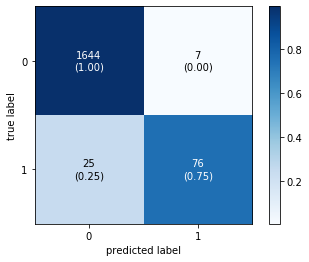

In [45]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(preds_probas_df_all_feat.y_true_values, preds_probas_df_all_feat.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

## Plot distribución positive probas 

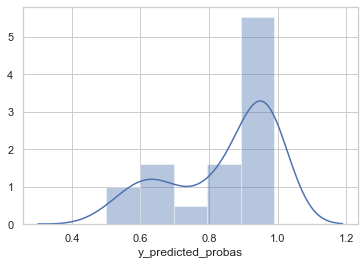

In [47]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df_all_feat.y_predicted_probas)

## ROC_AUC VS Precision_Recall AUC

In [53]:
from sklearn.metrics import roc_auc_score

print('ROC auc con validation set all features: %.3f' % roc_auc_score(y_test, preds_probas_df_all_feat.y_predicted_probas))

ROC auc con validation set all features: 0.995


In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, preds_probas_df_all_feat.y_predicted_probas)
auc_score = auc(recall, precision)
print('Precision-Recall AUC: %.3f' % auc_score)

Precision-Recall AUC: 0.945


## Como era de esperar, el valor de PR AUC da un valor inferior, más realista en datasets desbalanceados

## Repetimos proceso con menos atributos según importancia

## Model feature importances

In [56]:
f = 'gain'
feature_importances = xgb_best_params.get_booster().get_score(importance_type= f)

feature_importances

{'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_median': 31.170453820000002,
 'Secondary Air Row #5 (Side 2)_min': 37.020100899999996,
 'Main Steam Turbine Control Valve #B_max': 18.48784697625,
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3_min': 2.4116260566666665,
 'Secondary Air Row #5 (Side 2)_max': 1.4580719026,
 'Boosted Overfire Air (Side 1)_max': 9.481203438749999,
 'Coal Feeder #1_max': 17.401293424000002,
 'Main Steam Second Desuperheater Control Valve position (Side 2)_max': 13.99543620825,
 'Secondary Air Row #3 (Side 2)_median': 9.500715601999998,
 'Boiler Feedwater Pressure_max': 8.110500576666666,
 'Air Heater #1 Differential Pressure_median': 18.49850283,
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_min': 10.46403466,
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_min': 29.019632976666667,
 'Main Steam Turbine Control Valve #B_mean': 22.9300136825,
 'Boosted Overfire Air (Side 2)_median': 4.862832684,
 'Dynamic Coal Classifier Rotational Speed 

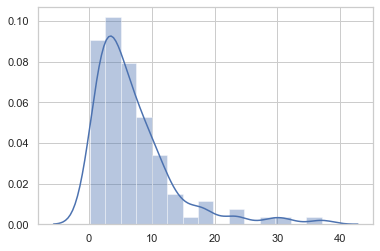

In [57]:
import seaborn as sns
sns.set(style="whitegrid")

f_importances = [value for key, value in feature_importances.items()]
ax = sns.distplot(f_importances)

In [58]:
selected_features = [key for key, value in feature_importances.items() if value > 4]
selected_features

['Flue Gas Induced Draft Fan #1 Blade Pitch Angle_median',
 'Secondary Air Row #5 (Side 2)_min',
 'Main Steam Turbine Control Valve #B_max',
 'Boosted Overfire Air (Side 1)_max',
 'Coal Feeder #1_max',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_max',
 'Secondary Air Row #3 (Side 2)_median',
 'Boiler Feedwater Pressure_max',
 'Air Heater #1 Differential Pressure_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_min',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_min',
 'Main Steam Turbine Control Valve #B_mean',
 'Boosted Overfire Air (Side 2)_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #1_median',
 'Dynamic Coal Classifier Rotational Speed Coal Mill #3_median',
 'Coal Feeder #5_min',
 'Secondary Air Fan #1 Temperature 2_min',
 'Flue Gas Induced Draft Fan #1 Blade Pitch Angle_mean',
 'Secondary Air Row #5 (Side 2)_median',
 'Boosted Overfire Air (Side 1)_mean',
 'Main Steam Second Desuperheater Control Valve position (Side 2)_m

## Retrain con most important features (con los mismos hiperparams del modelo copn el que se han escogido los most important features)

In [59]:
features_to_train_on = ['DAYS_TILL_SLAG'] + selected_features 


In [65]:
best['objective'] = 'binary:logistic'
#params= best
params = {'colsample_bytree': 0.6, 'gamma': 0.17, 'learning_rate': 0.33, 'max_depth': 6, 'min_child_weight': 6.0, 'n_estimators': 31, 'scale_pos_weight': 0.6401699668683631, 'subsample': 0.93}
xgb = XGBClassifier(**params) 

X_test_attributes = [x for x in features_to_train_on if x not in ['DAYS_TILL_SLAG']]

eval_set = [(X_test[X_test_attributes], y_test)]
global days_until_slag
days_until_slag = X_test['DAYS_TILL_SLAG']

xgb_best_params = xgb.fit(X_train[X_test_attributes], y_train, eval_metric=eval_metric_function_for_training_xgboost, eval_set=eval_set, verbose=True)        

best_params_xgb_predictions = xgb_best_params.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('return_edp_savings_function'))
confusion_matrix(y_test, best_params_xgb_predictions)

[0]	validation_0-error:0.0371	validation_0-eval_metric_function_for_training_xgboost:0
[1]	validation_0-error:0.034247	validation_0-eval_metric_function_for_training_xgboost:0
[2]	validation_0-error:0.02968	validation_0-eval_metric_function_for_training_xgboost:0
[3]	validation_0-error:0.026826	validation_0-eval_metric_function_for_training_xgboost:0
[4]	validation_0-error:0.027397	validation_0-eval_metric_function_for_training_xgboost:0
[5]	validation_0-error:0.025685	validation_0-eval_metric_function_for_training_xgboost:0
[6]	validation_0-error:0.021119	validation_0-eval_metric_function_for_training_xgboost:0
[7]	validation_0-error:0.02226	validation_0-eval_metric_function_for_training_xgboost:0
[8]	validation_0-error:0.019977	validation_0-eval_metric_function_for_training_xgboost:0
[9]	validation_0-error:0.018836	validation_0-eval_metric_function_for_training_xgboost:0
[10]	validation_0-error:0.019406	validation_0-eval_metric_function_for_training_xgboost:0
[11]	validation_0-error:

array([[1646,    5],
       [  21,   80]], dtype=int64)

## Construimos dataframe resultados

In [70]:
best_params_xgb_predictions_thr_4 = xgb_best_params.predict(X_test[X_test_attributes])
best_params_xgb_probas_thr_4 = xgb_best_params.predict_proba(X_test[X_test_attributes])

preds_probas_df_thr_4 = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values':best_params_xgb_predictions_thr_4, 'y_predicted_probas': best_params_xgb_probas_thr_4[:, 1]})

positive_preds_probas_df_thr_4 = preds_probas_df_thr_4[preds_probas_df_thr_4.y_predicted_values==1]

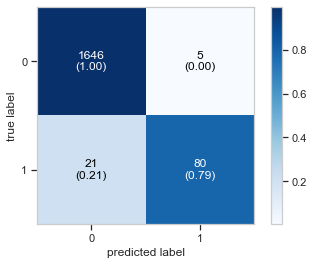

In [74]:

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(preds_probas_df_thr_4.y_true_values, preds_probas_df_thr_4.y_predicted_values),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

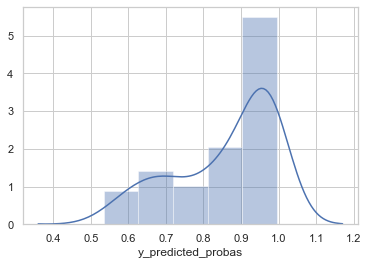

In [76]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.distplot(positive_preds_probas_df_thr_4.y_predicted_probas)

## ROC_AUC VS Precision-Recall AUC

In [77]:
from sklearn.metrics import roc_auc_score

print('ROC auc con validation set all features: %.3f' % roc_auc_score(y_test, preds_probas_df_thr_4.y_predicted_probas))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, preds_probas_df_thr_4.y_predicted_probas)
auc_score = auc(recall, precision)
print('Precision-Recall AUC: %.3f' % auc_score)

ROC auc con validation set all features: 0.996
Precision-Recall AUC: 0.962


# Vemos que una ligera mejora en la distribución de nuestras prediction probabilities ha significado también una ligera mejora en nuestros valores de AUC, sobre todo de la precision-recall curve

# Repito entrenamientos con eval_metric = 'auc'

In [ ]:
def evaluate_model_with_slag_days_auc(dataX, dataY):
    from tqdm import tqdm
    from sklearn.model_selection import KFold
    
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    k = 0
    for train_ix, test_ix in tqdm(kfold.split(dataX)):
        print('kfold {}'.format(k))
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX.iloc[train_ix], dataY.iloc[train_ix], dataX.iloc[test_ix], \
                                       dataY.iloc[test_ix]
        
        days_until_slag = testX['DAYS_TILL_SLAG'] 
        
        # fit model
        history = defined_model.fit(trainX[features_to_train_on], trainY, #early_stopping_rounds=10, 
                                    eval_metric= 'auc',
                                    eval_set=[(testX[features_to_train_on], testY)])                               
        # evaluate model
        y_preds = defined_model.predict(testX[features_to_train_on])
        
        #score = return_edp_cost_function(y_preds, testY) 
        ###########################################################
        costs_dict = {'fp_cost': 19253, 'fn_cost': 350000}
        
        y_true_values = testY
        true_predicted_tuples = pd.DataFrame({'y_true': y_true_values, 'y_predicted': y_preds, \
                                              'days_till_slag': days_until_slag})
        true_predicted_tuples = true_predicted_tuples.reset_index(drop=True)
        #true positives, false positives and false negatives number
        tp_savings = 0
        
        first_tp_detected = False

        while first_tp_detected==False:
            for index in true_predicted_tuples.index:
                # TRUE POSITIVE condition:
                if ((true_predicted_tuples.iloc[index]['y_true']==1)&(true_predicted_tuples.iloc[index]['y_predicted']==1)):
                    tp_savings += return_true_positive_savings(true_predicted_tuples.iloc[index]['days_till_slag'])
                break
            first_tp_detected = True
        
        fp_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==0)&(true_predicted_tuples.y_predicted==1)])
        fn_number = len(true_predicted_tuples[(true_predicted_tuples.y_true==1)&(true_predicted_tuples.y_predicted==0)])

        final_cost =  ((costs_dict['fp_cost'])*fp_number) + ((costs_dict['fn_cost'])*fn_number) - tp_savings
        ##########################################################
        score = final_cost
        
        print('score en evaluate_model_with_slag_days', score)
        
        #print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(score)
        histories.append(history)
        
        k = k + 1
        
    return defined_model, scores, histories

In [ ]:
### Hiperparam. con Bayesian optimization
from hyperopt import hp
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def return_model_scores(params, dataX, dataY, n_folds=5):
    import numpy as np
    
    defined_model, edp_cost_scores, histories = evaluate_model_with_slag_days_auc(dataX = dataX, dataY = dataY)   
    
    return np.array(edp_cost_scores).mean()


param_space = {'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.2, 0.8)}

# DEFINO ESTAS VARIABLES GLOBALES AL NO METERLAS COMO PARAMS. DE ENTRADA EN EL BAYESIAN HYPERP.
dataX = X_train
dataY = y_train
assert len(X_train)==len(y_train)
n_folds=5

global best
best = 0
i = 0
def f(params):
    cost = return_model_scores(params, dataX, dataY, n_folds=5)  
    if i == 0:
        best = cost
    
    if cost < best:
        best = cost
        print('new best:', best, params)
    
    return {'loss': cost, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)

#%%
print ('best:')
print (best)


In [ ]:

best_params_con_auc = {'colsample_bytree': 0.48, 'gamma': 0.11, 'learning_rate': 0.36, 'max_depth': 10, 'min_child_weight': 9.0, 'n_estimators': 8, 'scale_pos_weight': 0.5753069149377273, 'subsample': 0.23}
'''
best_params_con_auc = {'colsample_bytree': 0.27, 'gamma': 0.24, 'learning_rate': 0.31, 'max_depth': 23, 'min_child_weight': 7.0, 'n_estimators': 14, 'scale_pos_weight': 0.21112719707036665, 'subsample': 0.6900000000000001}
'''



In [ ]:
best['objective'] = 'binary:logistic'
params= best_params_con_auc
xgb = XGBClassifier(**params) #'multi:softprob')

X_test_attributes = [x for x in X_test.columns if x not in ['DAYS_TILL_SLAG']]

eval_set = [(X_test[X_test_attributes], y_test)]
global days_until_slag
days_until_slag = X_test['DAYS_TILL_SLAG']

xgb_best_params = xgb.fit(X_train[X_test_attributes], y_train, eval_metric='auc', eval_set=eval_set, verbose=True)        
              
best_params_xgb_predictions = xgb_best_params.predict(X_test[X_test_attributes])
print('with eval_metric = {}'.format('auc'))
confusion_matrix(y_test, best_params_xgb_predictions)

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, best_params_xgb_predictions),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [ ]:
best_params_auc_eval_results_df = pd.DataFrame({'y_true_values': y_test, 'y_predicted_values': best_params_xgb_predictions})
best_params_auc_eval_results_df[best_params_auc_eval_results_df.y_predicted_values==1]


In [ ]:
best_params_auc_eval_results_df[best_params_auc_eval_results_df.y_true_values==1]